<a href="https://colab.research.google.com/github/effection00/codestates/blob/main/note/234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

# 경고 제거
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [2]:
import pandas as pd

#데이터 불러오기
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/lending_club/lending_club_sampled.csv')
# to_datetime 날짜 형태로 변경
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)

df

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,9816,67838765,NaN,10000.0,10000.0,10000.0,36 months,11.99,332.10,C,C1,registered nurse,10+ years,MORTGAGE,110000.0,Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,333xx,FL,20.59,2.0,May-2005,670.0,674.0,2.0,18.0,NaN,18.0,0.0,30920.0,65.9,40.0,w,0.0,...,300580.0,63123.0,13200.0,53680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,28262,66552700,NaN,7500.0,7500.0,7500.0,36 months,8.38,236.34,B,B1,Human Resources,1 year,OWN,51700.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,322xx,FL,21.36,0.0,Aug-1993,705.0,709.0,1.0,67.0,NaN,13.0,0.0,13152.0,43.0,34.0,w,0.0,...,55390.0,36559.0,17600.0,24990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1168599,30646090,NaN,5000.0,5000.0,5000.0,36 months,14.49,172.09,C,C4,Social worker case mgr,10+ years,MORTGAGE,60000.0,Not Verified,2014-10-01,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,331xx,FL,16.34,0.0,Apr-1982,685.0,689.0,1.0,34.0,NaN,14.0,0.0,11069.0,63.3,35.0,w,0.0,...,271013.0,41229.0,10200.0,37513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,246652,51989023,NaN,8250.0,8250.0,8250.0,36 months,16.99,294.10,D,D3,Account Manager,5 years,MORTGAGE,90000.0,Verified,2015-06-01,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,600xx,IL,11.75,0.0,Sep-2000,670.0,674.0,4.0,NaN,NaN,7.0,0.0,1593.0,34.6,16.0,f,0.0,...,50755.0,39773.0,4000.0,46155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1620660,861046,NaN,8000.0,8000.0,8000.0,36 months,7.49,248.82,A,A4,GSF Plastics Corp.,< 1 year,RENT,24000.0,Source Verified,2011-09-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 08/25/11 > I want to pay o...,credit_card,pay off commercebank,770xx,TX,12.05,0.0,Feb-1991,755.0,759.0,0.0,NaN,91.0,3.0,1.0,8031.0,46.4,13.0,f,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [3]:
# issue_d 인덱스 설정 및 기준으로 정렬
df.set_index('issue_d').sort_index()

## 새 feature 형성
# 실수형 이자율 
df['interest_rate'] = df['int_rate'].astype(float)
# 월간 부채
df['monthly_debts'] = df['annual_inc'] / 12 * df['dti'] / 100

# 일부 특성만 사용

col = ['annual_inc', # 연수입
           'fico_range_high', # 신용점수 
           'funded_amnt', # 대출
           'title', # 대출 목적
           'monthly_debts', # 월간 부채
           'interest_rate'] # 이자율

df = df[col]
df = df.dropna()

df

,annual_inc,fico_range_high,funded_amnt,title,monthly_debts,interest_rate
0,110000.0,674.0,10000.0,Home improvement,1887.416667,11.99
1,51700.0,709.0,7500.0,Debt consolidation,920.260000,8.38
2,60000.0,689.0,5000.0,Debt consolidation,817.000000,14.49
3,90000.0,674.0,8250.0,Debt consolidation,881.250000,16.99
4,24000.0,759.0,8000.0,pay off commercebank,241.000000,7.49
...,...,...,...,...,...,...
97586,54995.0,729.0,10000.0,Credit card refinancing,569.198250,6.03
97587,80000.0,714.0,10000.0,Other,1474.000000,14.31
97588,77175.0,709.0,20000.0,Debt consolidation,546.013125,7.89
97589,150000.0,669.0,15000.0,Credit card refinancing,1591.250000,13.33


In [4]:
#10000개, 10000개는 검증셋과 테스트셋
#나머지는 학습셋

#테스트셋 : 마지막 만개
test = df[-10000:]
#검증셋 : 테스트셋 뺀 후 마지막 만 개
val = df[-20000:-10000]
#학습셋 : 마지막 20000개 뺀 나머지
train = df[:-20000]

In [5]:
print(df.columns)
test.shape, val.shape, train.shape

Index(['annual_inc', 'fico_range_high', 'funded_amnt', 'title',
       'monthly_debts', 'interest_rate'],
      dtype='object')


((10000, 6), (10000, 6), (76408, 6))

In [6]:
train

,annual_inc,fico_range_high,funded_amnt,title,monthly_debts,interest_rate
0,110000.0,674.0,10000.0,Home improvement,1887.416667,11.99
1,51700.0,709.0,7500.0,Debt consolidation,920.260000,8.38
2,60000.0,689.0,5000.0,Debt consolidation,817.000000,14.49
3,90000.0,674.0,8250.0,Debt consolidation,881.250000,16.99
4,24000.0,759.0,8000.0,pay off commercebank,241.000000,7.49
...,...,...,...,...,...,...
77328,80000.0,729.0,7000.0,Debt consolidation,1106.000000,5.32
77329,20856.0,724.0,10000.0,Home Improvement Loan,188.051600,10.59
77330,110000.0,774.0,22000.0,Debt consolidation,1220.083333,6.39
77331,60000.0,674.0,5000.0,Major purchase,725.000000,11.99


In [7]:
# 고객별 대출 이자율 측정하기 
# target : interest_rate

target = 'interest_rate'
col_name = train.drop(['interest_rate'],axis=1).columns



X_train = train[col_name]
y_train = train[target]
X_val = val[col_name]
y_val= val[target]
X_test = test[col_name]
y_test = test[target]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


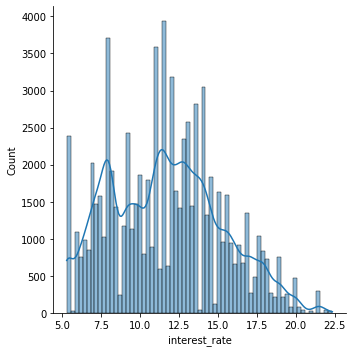

In [8]:
# 실행한 브라우저에서 바로 볼 수 있도록
%matplotlib inline

# target 분포확인 
import seaborn as sns
sns.displot(y_train, kde=True);

In [9]:
!pip install category_encoders

In [10]:
X_train

,annual_inc,fico_range_high,funded_amnt,title,monthly_debts
0,110000.0,674.0,10000.0,Home improvement,1887.416667
1,51700.0,709.0,7500.0,Debt consolidation,920.260000
2,60000.0,689.0,5000.0,Debt consolidation,817.000000
3,90000.0,674.0,8250.0,Debt consolidation,881.250000
4,24000.0,759.0,8000.0,pay off commercebank,241.000000
...,...,...,...,...,...
77328,80000.0,729.0,7000.0,Debt consolidation,1106.000000
77329,20856.0,724.0,10000.0,Home Improvement Loan,188.051600
77330,110000.0,774.0,22000.0,Debt consolidation,1220.083333
77331,60000.0,674.0,5000.0,Major purchase,725.000000


In [11]:
# 선형회귀 학습 

# targetencoder 사용 : 
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# 타겟인코더 fit할 때 X,Y 둘다 필요
#ec = TargetEncoder()
#ec.fit_transform(X_train,y_train)


linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R2:',linear.score(X_val,y_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


R2: 0.25353362686216807


In [12]:
linear

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['title'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=1, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [13]:
# 회귀계수 : 가중치, 기울기 파라미터  >> 특성이 target에 어떻게 영향을 주는지 알 수 있음
cofficients = linear.named_steps['linearregression'].coef_
pd.Series(cofficients, col_name)

annual_inc        -0.000007
fico_range_high   -0.052147
funded_amnt        0.000023
title              1.007203
monthly_debts      0.000135
dtype: float64

In [14]:
 -0.052147 * 100

 # 신용점수가 100점 오르면 5%의 이자율이 줄어듬

-5.2147

In [15]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train = encoder.fit_transform(X_train) 
X_val = encoder.transform(X_val)


boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)


# train, val 합친 eval set 준비
eval_set = [(X_train,y_train), 
            (X_val, y_val)]

boosting.fit(X_train, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50  #n_estimators 수치 높을 때 사용
         )



[0]	validation_0-rmse:9.5679	validation_1-rmse:9.60621
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:7.87603	validation_1-rmse:7.92155
[2]	validation_0-rmse:6.56377	validation_1-rmse:6.61839
[3]	validation_0-rmse:5.56228	validation_1-rmse:5.61687
[4]	validation_0-rmse:4.80996	validation_1-rmse:4.87336
[5]	validation_0-rmse:4.25565	validation_1-rmse:4.32512
[6]	validation_0-rmse:3.85674	validation_1-rmse:3.92572
[7]	validation_0-rmse:3.57351	validation_1-rmse:3.64065
[8]	validation_0-rmse:3.37588	validation_1-rmse:3.44191
[9]	validation_0-rmse:3.23629	validation_1-rmse:3.30144
[10]	validation_0-rmse:3.14345	validation_1-rmse:3.20877
[11]	validation_0-rmse:3.07627	validation_1-rmse:3.14035
[12]	validation_0-rmse:3.03342	validation_1-rmse:3.09517
[13]	validation_0-rmse:3.00226	validation_1-rmse:3.06219
[14]	validation_0-rmse:2.97947	validation_1-rmse:3.039

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [16]:
# 감쳐진 그래디언트 부스팅 결과를 해석하기 위해 ?> PDP 사용

# 트리모델은 특성과 타겟과의 관계를 해석할 수 없음
import matplotlib.pyplot as plt
# 이미지 화질 조정
plt.rcParams['figure.dpi'] = 144

In [17]:
!pip install pdpbox

##개별 특성과 타겟과의 관계


(<Figure size 2160x1368 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f438b1d5e10>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f438b1fa810>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


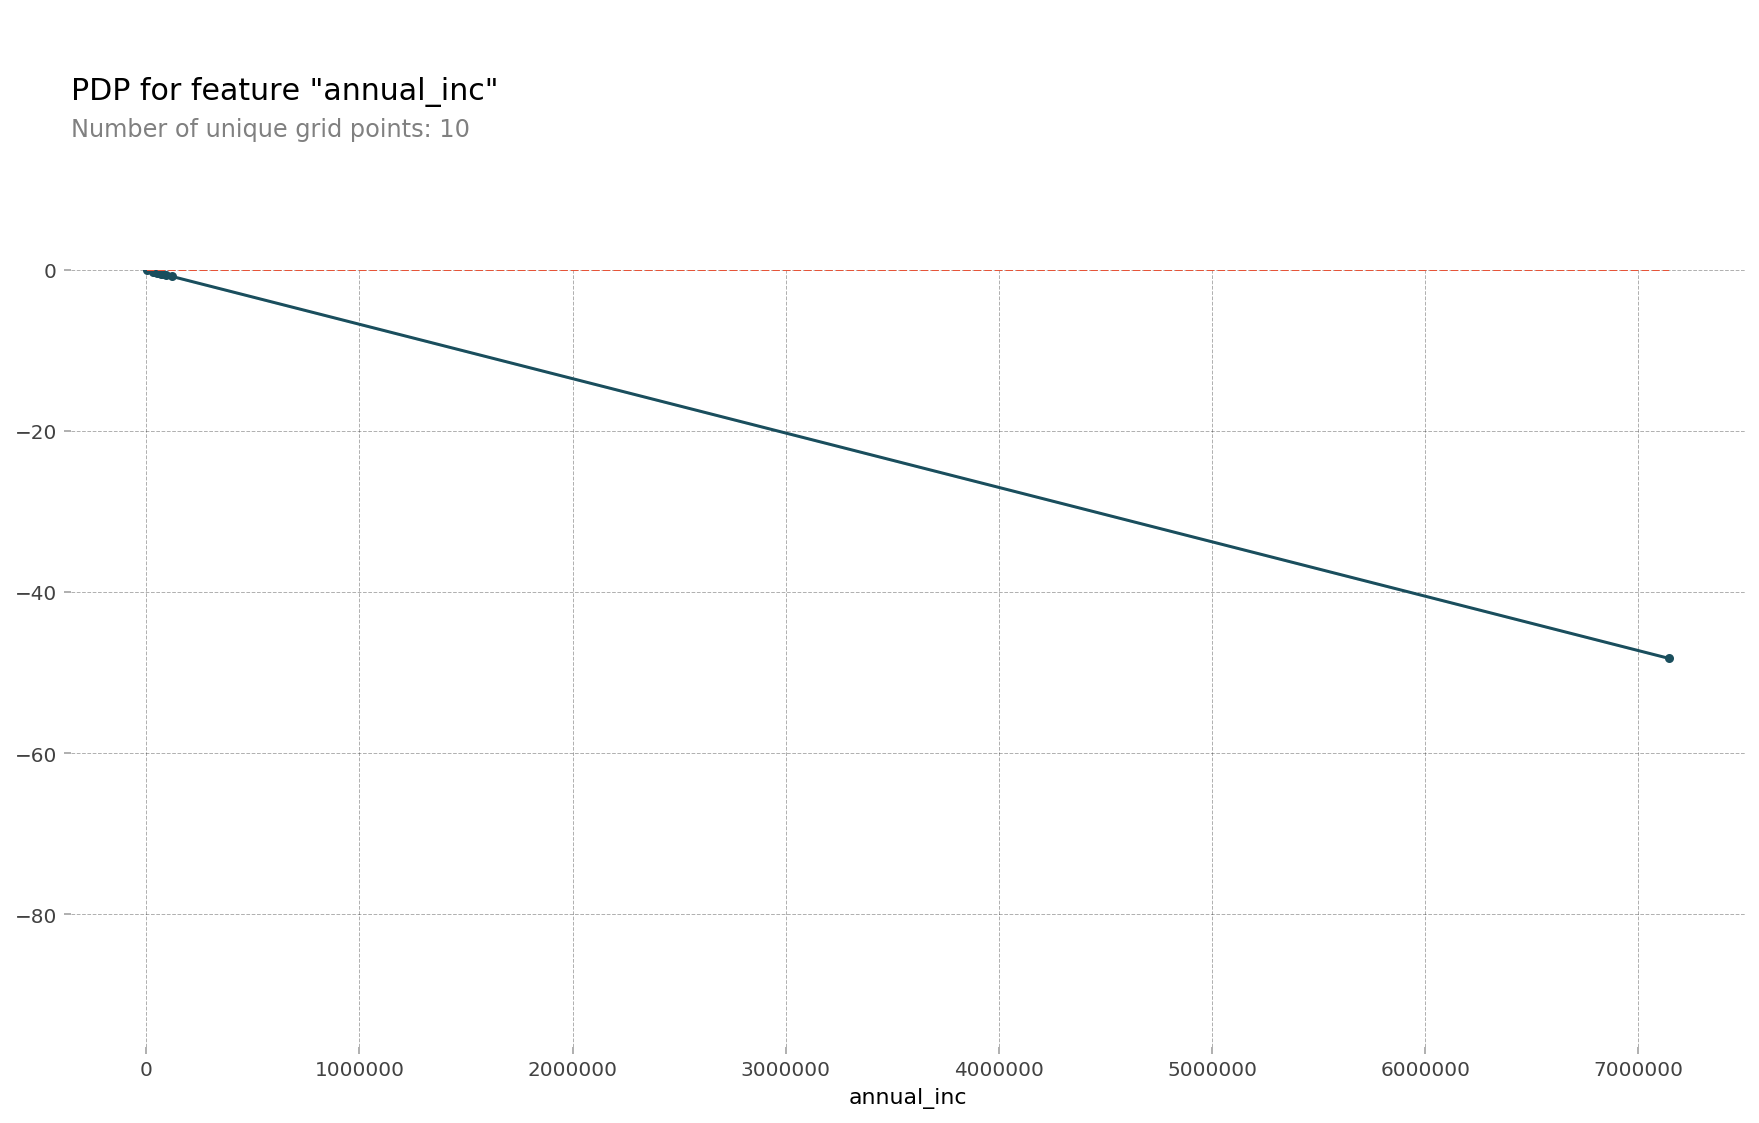

In [18]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'annual_inc'

# 훈련시킨 선형회귀 모델의 특성 PDP 그려보기 
isolate = pdp_isolate(
    model =linear,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature, #내가 알고싶은 특성
    grid_type = 'percentile',
    num_grid_points=10 # default = 10 
)
pdp_plot(isolate, feature_name=feature)

In [19]:
isolate = pdp_isolate(
    model = boosting,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
    
)

(10000, 150000)

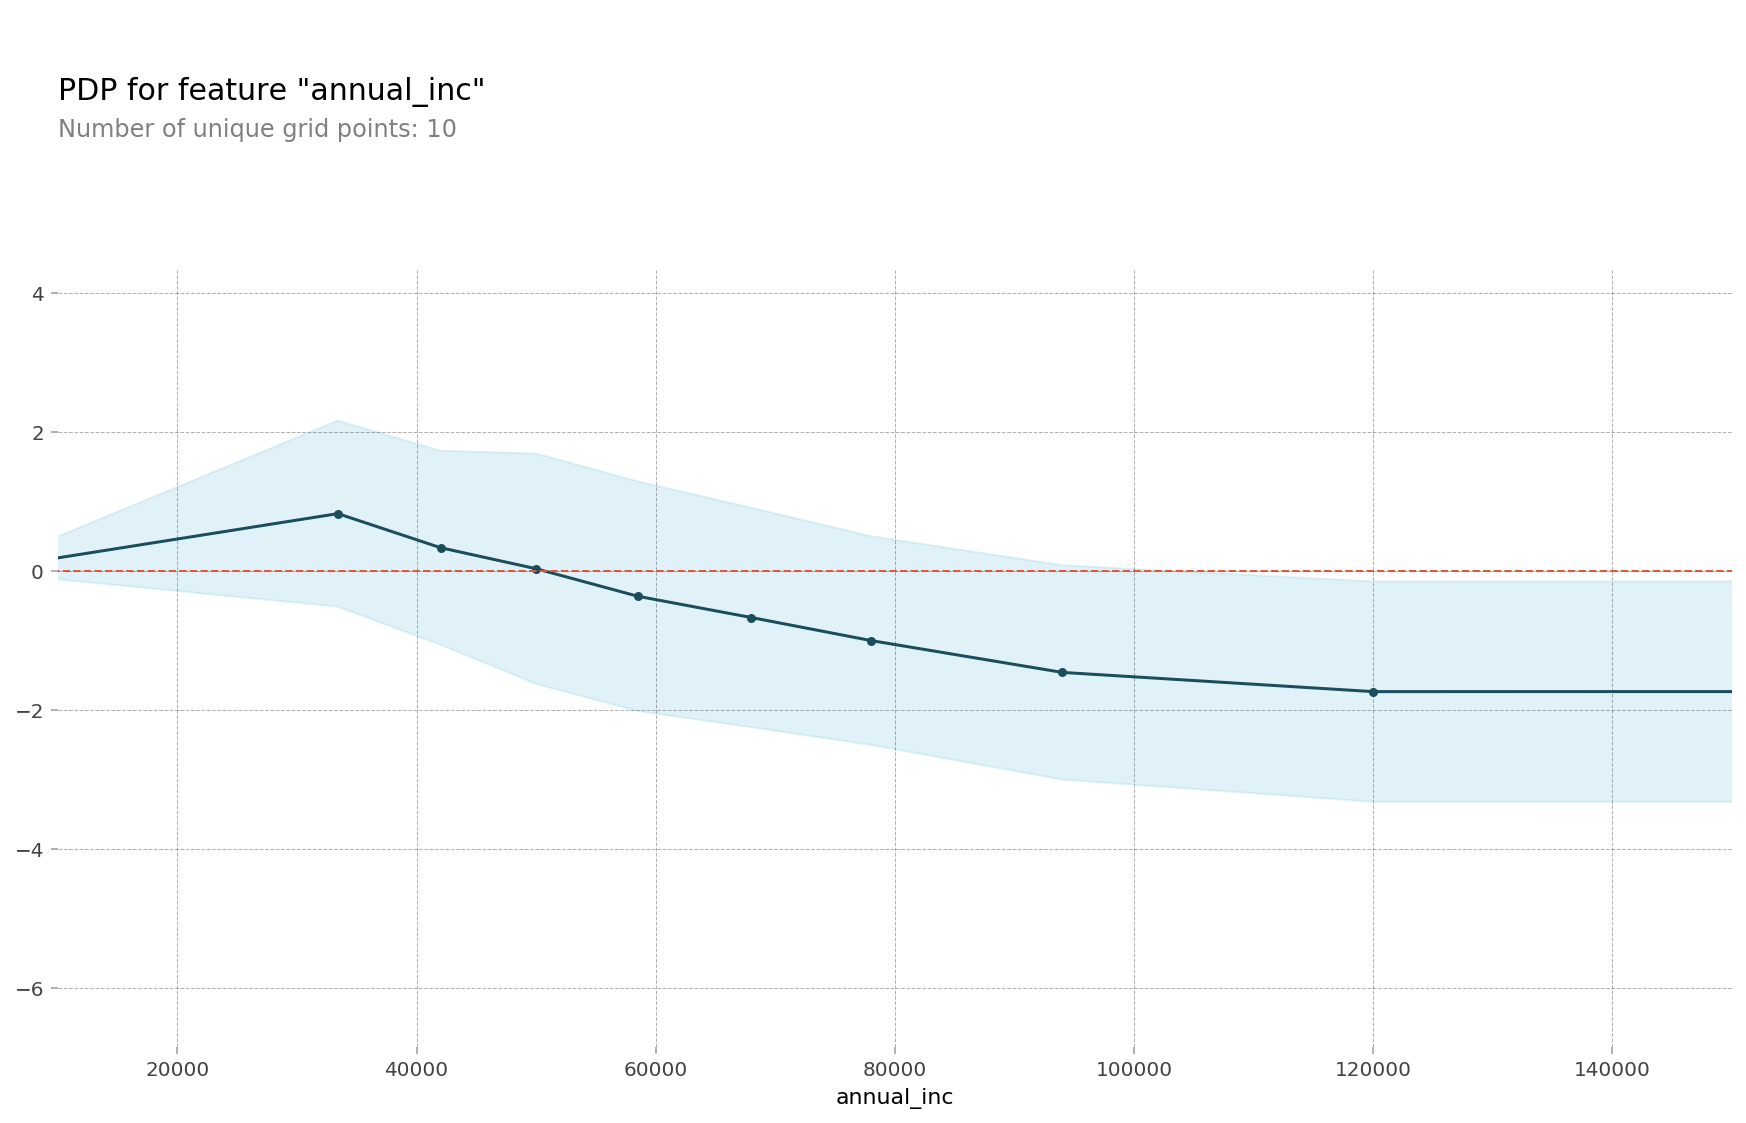

In [20]:
pdp_plot(isolate, feature_name=feature)
plt.xlim(10000,150000)

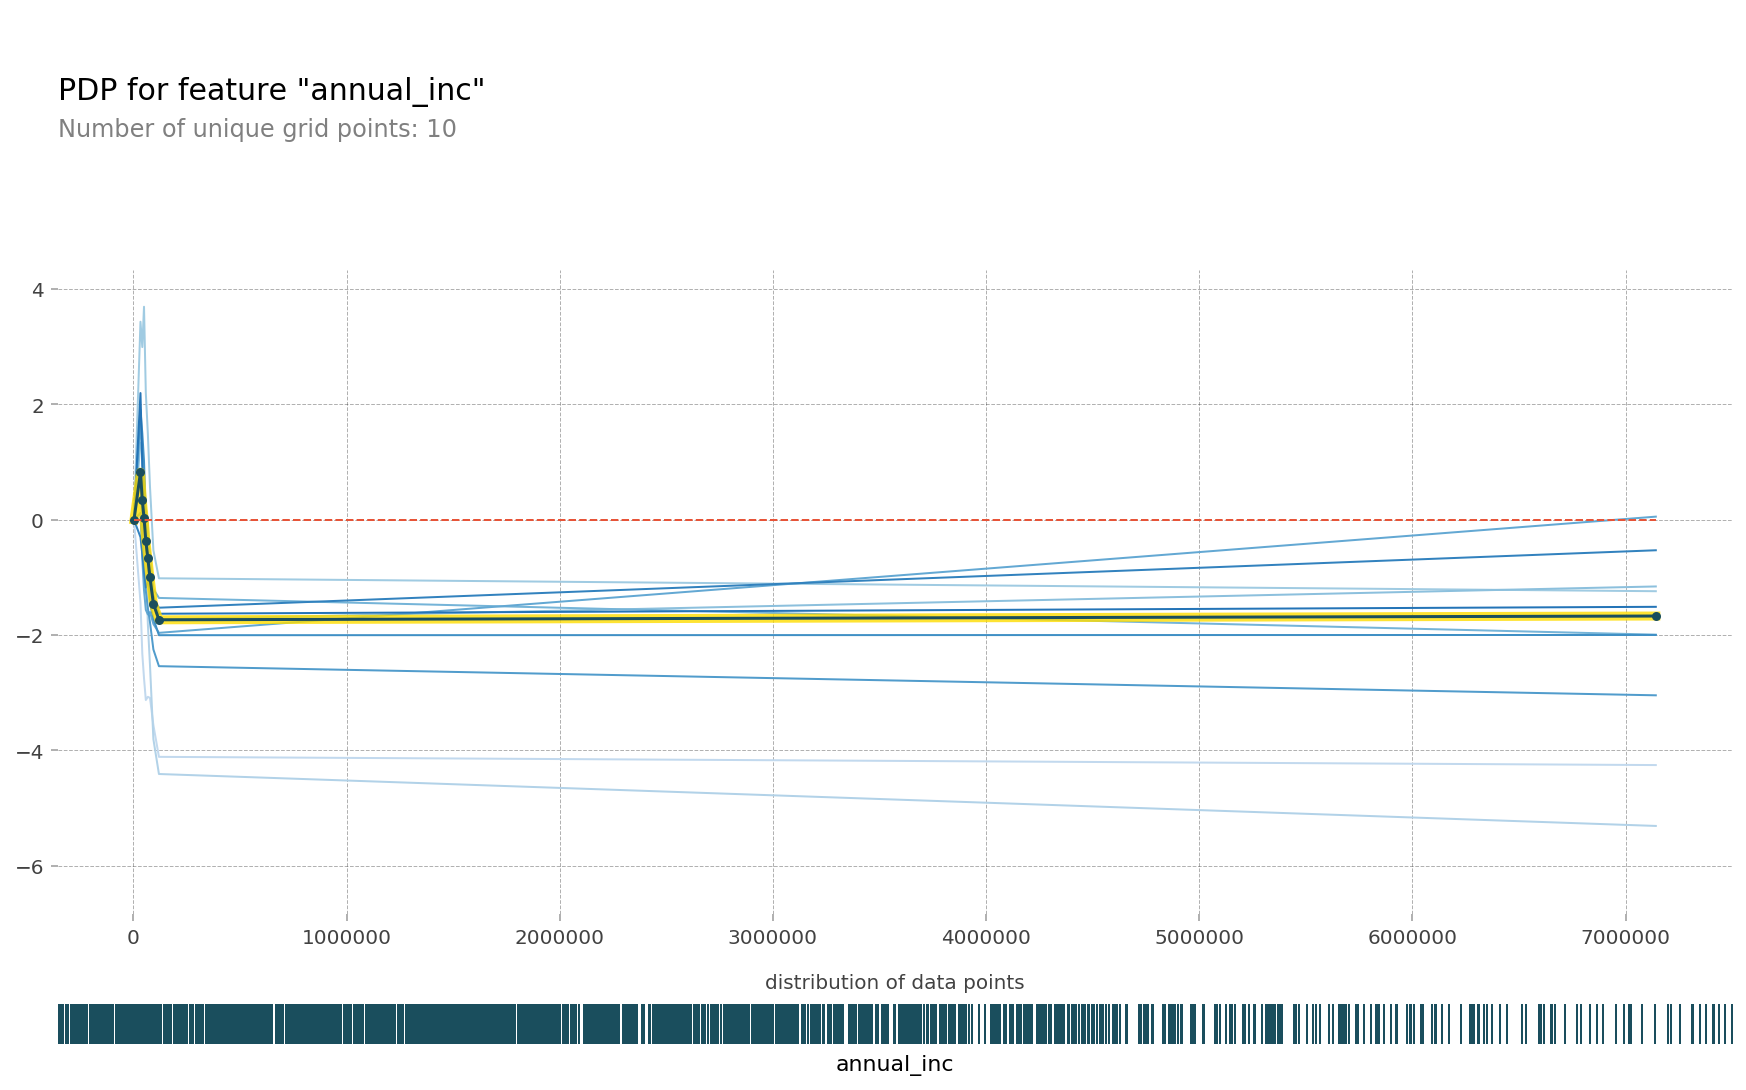

In [21]:
# ICE 곡선은 하나의 관측치에 관심특성을 변화시키며 타겟값 변화를 알아보는 것 ICE의 평균으로 그려짐

pdp_plot(isolate
         , feature_name=feature
         , plot_lines=True # ICE plots 추가
         , frac_to_plot=10 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True)  

plt.xlim(20000,150000);

In [22]:
# PDP로하는 예측 수 

isolate = pdp_isolate(
    model = boosting,
    dataset= X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=100
)

print("예측수:", len(X_val)*100)

예측수: 1000000


(<Figure size 2160x1368 with 3 Axes>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f438713e350>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f43871d2bd0>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f438720eb50>})

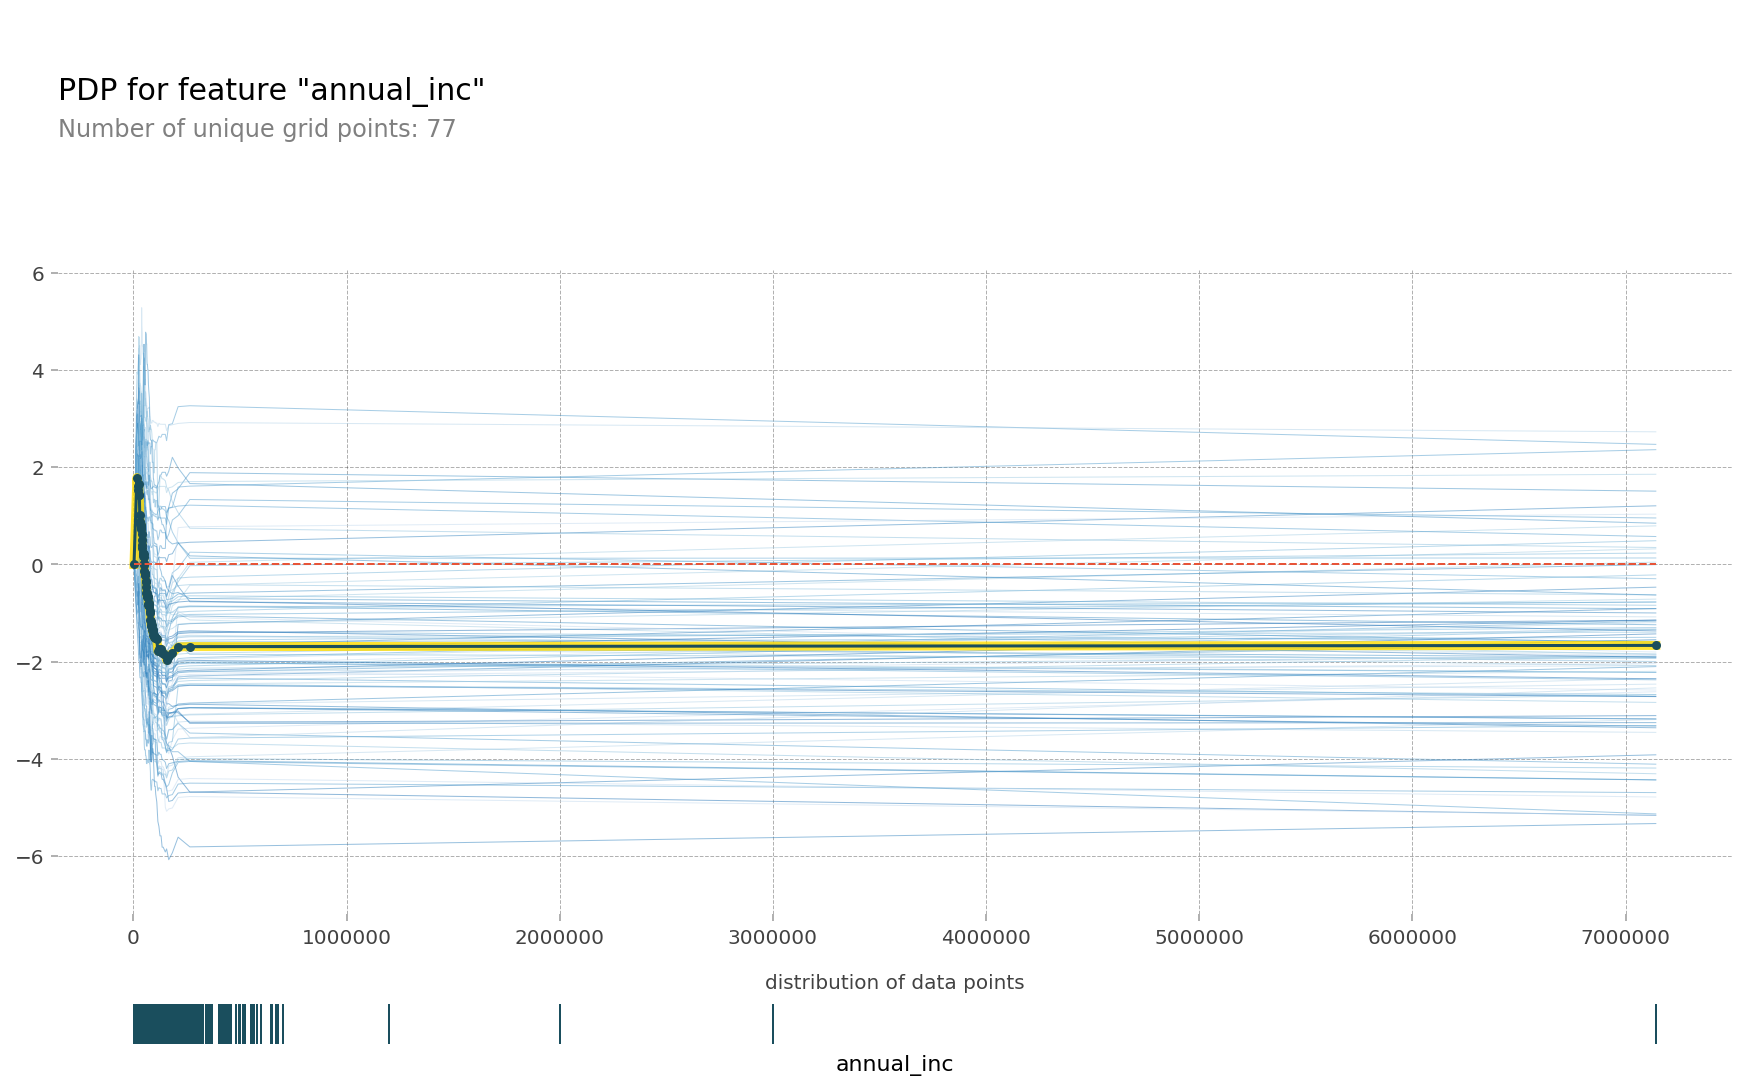

In [23]:
pdp_plot(isolate,
         feature_name=feature,
         plot_lines=True,
         frac_to_plot = 100, 
         plot_pts_dist = True)

##개별 특성들간의 관계


In [24]:
# isolate 대신 interact 사용
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['annual_inc', 'fico_range_high']

inter = pdp_interact(
    model = boosting,
    dataset = X_val,
    model_features = X_val.columns,
    features = features # s가 붙음
)

(<Figure size 1080x1368 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4386f44710>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4386f26b10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


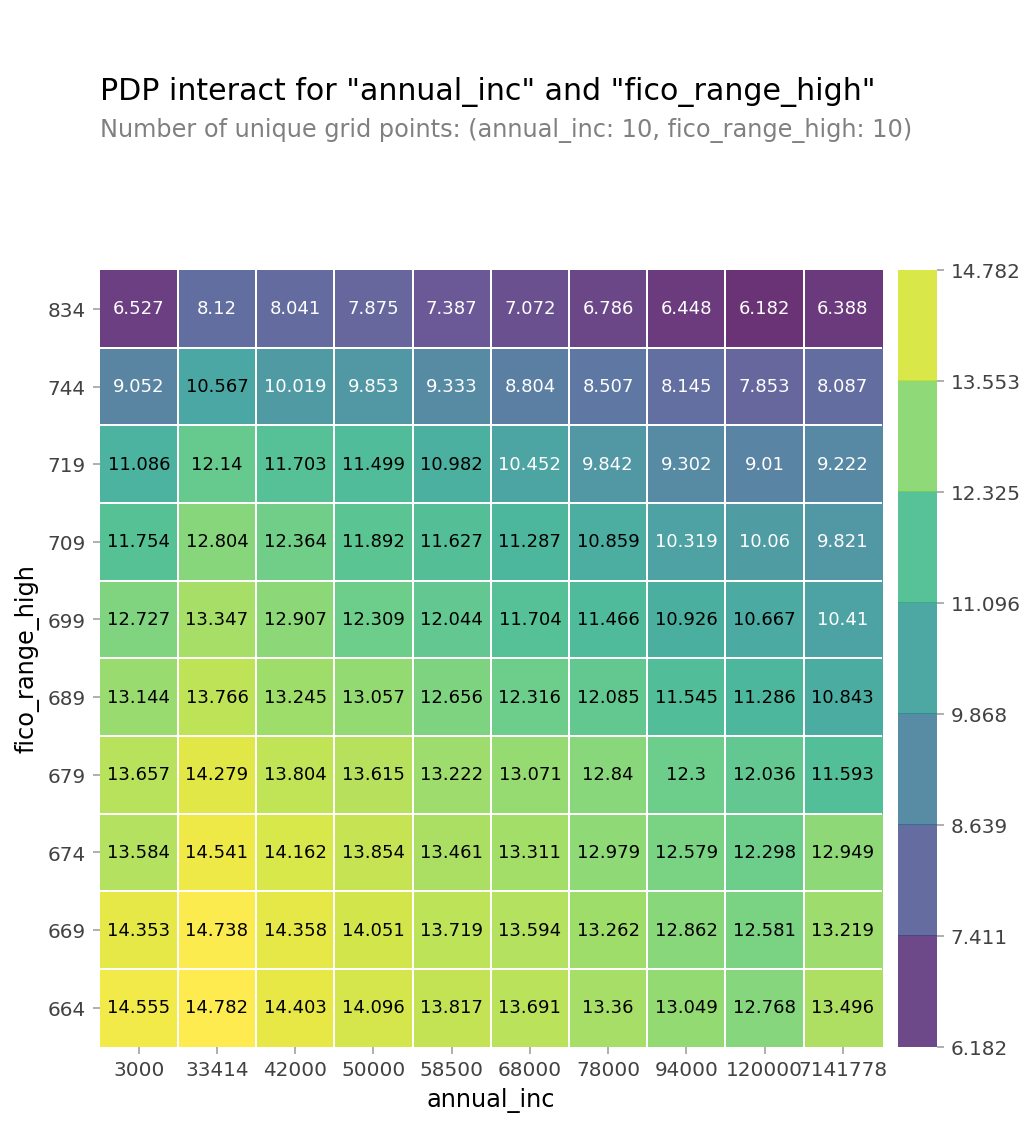

In [25]:
pdp_interact_plot(inter, plot_type='grid',feature_names=features)

# 3차원으로도 표현 가능

(<Figure size 2160x1368 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f438721cfd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4387296910>})

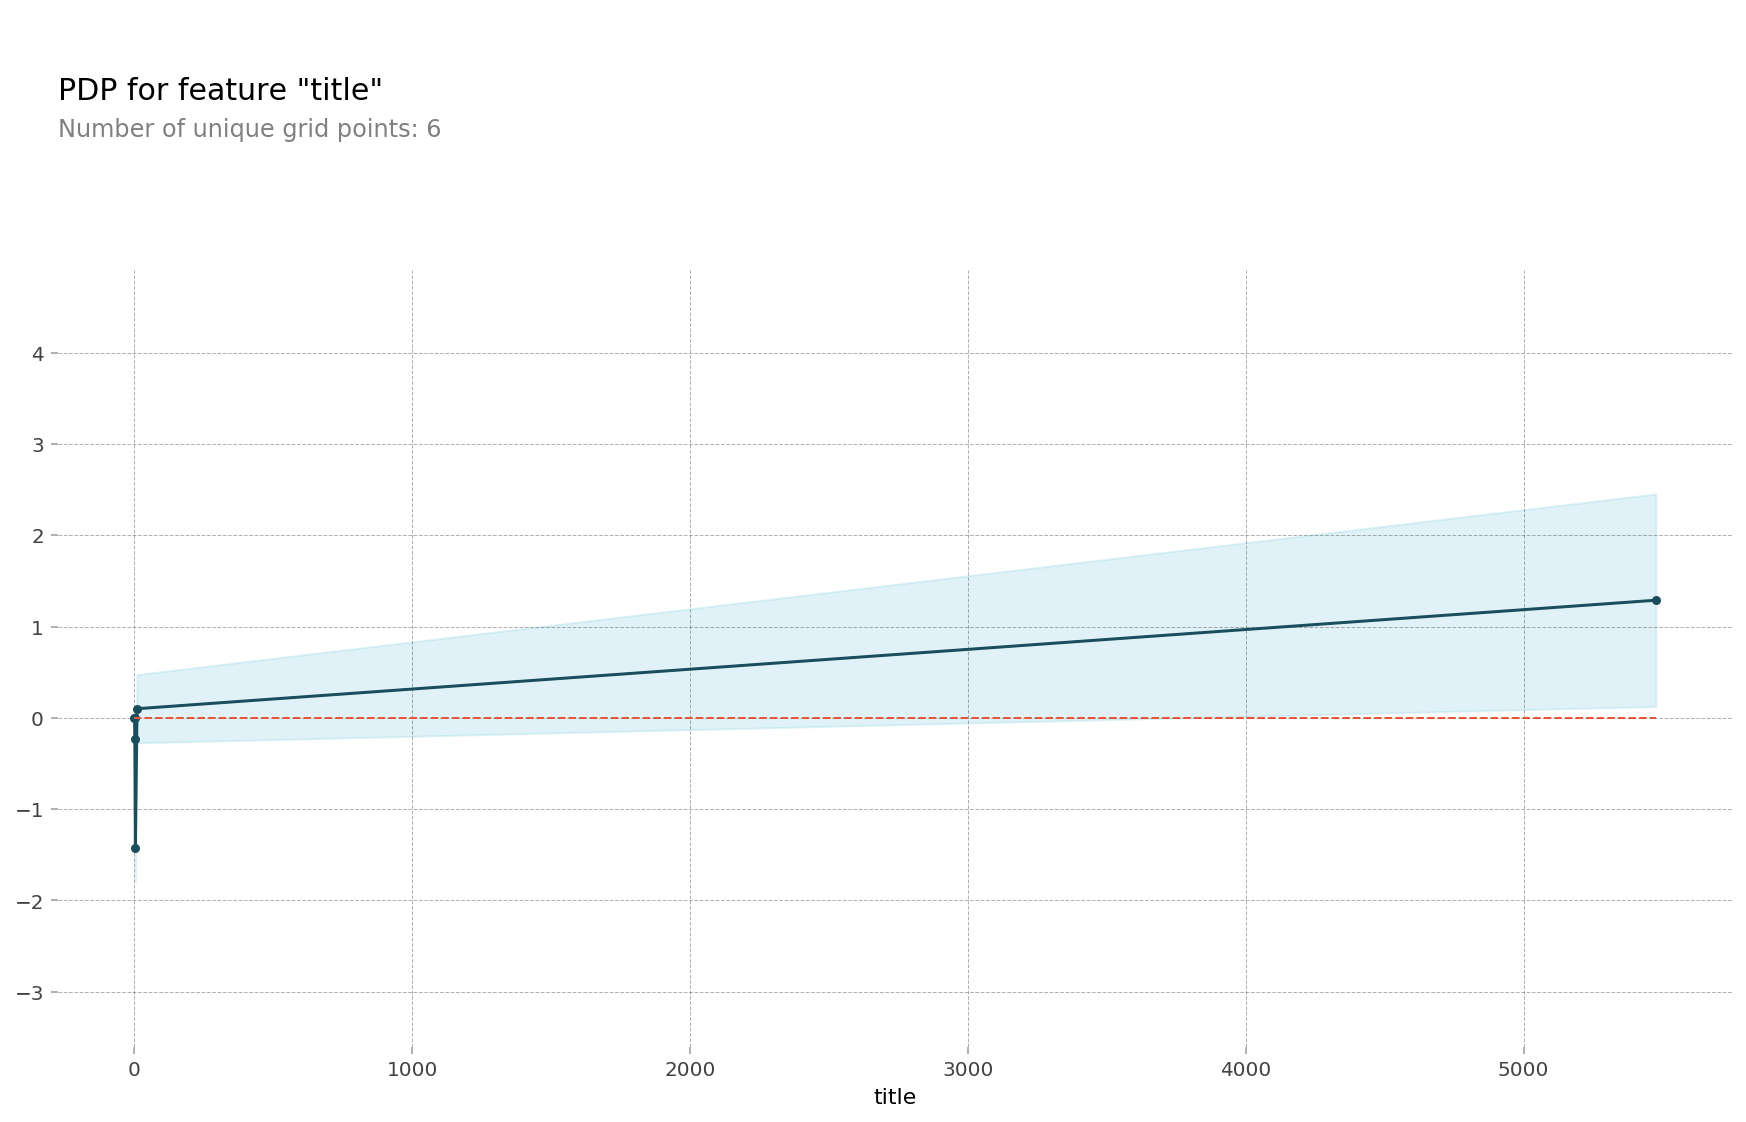

In [26]:
# PDP표현 시 범주화 특성에 인코딩되기 전의 값 보여주기

import matplotlib.pyplot as plt
from pdpbox import pdp

feature = 'title'
pdp_dist = pdp.pdp_isolate(model = boosting, dataset = X_val, model_features=X_val.columns, feature = feature)
pdp.pdp_plot(pdp_dist, feature)

In [27]:
import numpy as np 


In [28]:

df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

print(df.shape)

# 조건문으로 양끝 제거
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['long'] >= np.percentile(df['long'], 0.05)) & 
        (df['long'] <= np.percentile(df['long'], 99.95)) &
        (df['lat'] >= np.percentile(df['lat'], 0.05)) & 
        (df['lat'] < np.percentile(df['lat'], 99.95))]


print(df.shape)

(21613, 21)
(21351, 21)


In [29]:
# split 2015/3/15 기준 

# format 설정 시 알아서 잘 형식 추정해줌
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
train = df[df['date'] < '2015-03-01']
test = df[df['date'] >= '2015-03-01']

In [30]:
train.shape, test.shape

((16660, 21), (4691, 21))

In [31]:
col = train.columns
col

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [32]:
features = ['bedrooms', 'bathrooms', 'long', 'lat']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [33]:
X_train

,bedrooms,bathrooms,long,lat
0,3,1.00,-122.257,47.5112
1,3,2.25,-122.319,47.7210
2,2,1.00,-122.233,47.7379
3,4,3.00,-122.393,47.5208
4,3,2.00,-122.045,47.6168
...,...,...,...,...
21608,3,2.50,-122.346,47.6993
21609,4,2.50,-122.362,47.5107
21610,2,0.75,-122.299,47.5944
21611,3,2.50,-122.069,47.5345


In [34]:
from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.0min finished


In [35]:
print("최적의 파라미터 : ", search.best_params_)
print("CV MAE", -search.best_score_)

최적의 파라미터 :  {'max_depth': 15, 'max_features': 0.6327377306009369, 'n_estimators': 166}
CV MAE 104223.9508287586


In [36]:
gb = GradientBoostingRegressor(max_depth = 15, 
                               max_features =0.6327377306009369,
                               n_estimators = 166)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)

In [37]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, pred)

102016.28321191327

In [38]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, pred)

102016.28321191327

In [39]:
!pip install shap

In [40]:
import shap

In [41]:
row = X_train.iloc[[200]]


In [42]:
# 게임이론에서 나온 shap : 목표에 달성하기 위해 각자 자신이 기여한 정도를 알 수 있음

# treeexplainer에 gb 먼저 넣기
explainer = shap.TreeExplainer(gb)
#shap value 안에 값 넣기 
shap_values = explainer.shap_values(row)

#force plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features =row
)

# 특정 sample 에서 Price(target)에 대해
# 긍정적인 영향을 준 feature: bathroom, bedrooms,lat
#부정적 영향을 준 feature : long 

In [43]:
shap_values = explainer.shap_values(X_train)

In [44]:

shap.initjs()
top_ind = np.argsor(-np.sum(np.abs(shap_values),0))

AttributeError: ignored